Explores correlation and p-values for abstract art and artphoto datasets

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [28]:
import numpy as np
import cv2
from os import listdir
from os.path import join as p_join
from os.path import abspath
from pathlib import Path 
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from skimage.feature import greycomatrix, greycoprops

%cd /content/drive/MyDrive/CP/Computational Photography
from feature_extraction import calculateGLCMFeatures, calculateHSVFeatures, calculateLaplacian, rgb_values, rms_contrast, calculateFeatures
from feature_transform import change_laplacian, change_bgr, change_hsv
PROJDIR=abspath('')

/content/drive/.shortcut-targets-by-id/1tMW7kRVrirU9R4wxlCq58YDRba-UZ3Tr/Computational Photography


In [3]:
# put the path to the folder here 
# if this is a shared folder: right click on the folder in "Shared with me" directory, and then click "Add shortcut to Drive". 
# then you can access the data from your drive!
#PROJDIR = '/content/drive/MyDrive/CP/Computational Photography'
print(PROJDIR)
DATA = p_join(PROJDIR, 'data')

/content/drive/MyDrive/CP/Computational Photography


path to art photo data set

In [4]:
ARTPHOTO = p_join(DATA, 'testImages_artphoto')
# list with labels
emotions_ap = listdir(ARTPHOTO) 
print(emotions_ap)
# list of folders:
emotion_folder = [p_join(ARTPHOTO, em) for em in emotions_ap]

['awe', 'disgust', 'anger', 'fear', 'sad', 'excite', 'content', 'amuse']


path to abstract art data set + load ground truth

In [5]:
ABSTRACT = p_join(DATA, 'testImages_abstract')
ABSTRACT_TRAIN = p_join(ABSTRACT, 'train')
# ground truth distribution from csv file, store in DataFrame
ground_truth_abstract = pd.read_csv(p_join(ABSTRACT, "ABSTRACT_groundTruth.csv"), sep=',')
ground_truth_abstract.columns = ['image', 'amuse', 'anger', 'awe', 'content', 'disgust', 'excite', 'fear', 'sad']
train_ground_truth_abstract = ground_truth_abstract.iloc[:224]

In [6]:
train_ground_truth_abstract

,image,amuse,anger,awe,content,disgust,excite,fear,sad
0,'0001.jpg',5,0,0,7,1,1,1,1
1,'0002.jpg',1,0,1,6,0,3,0,1
2,'0003.jpg',1,3,1,0,1,3,2,2
3,'0004.jpg',0,1,0,2,0,0,2,8
4,'0005.jpg',1,0,2,6,4,2,0,1
...,...,...,...,...,...,...,...,...,...
219,'0223.jpg',1,0,1,4,2,2,3,4
220,'0224.jpg',0,1,3,0,3,3,2,2
221,'0225.jpg',0,0,1,0,1,1,2,7
222,'0226.jpg',0,0,0,0,1,0,2,10


Functions to calculate (normalized) GLCM, blurriness (laplace) and HSV features

In [7]:
def extractFeaturesAbstract(TRAIN: str, emotions: list, groundtruth: pd.DataFrame):
    """
    @param TRAIN        path to training data of abstract data set
    @param emotions     list of emotions in the data set
    @param groundtruth  dataframe with a row for each image that stores image name and probability for each emotion
    @return dataframe with row for each image containing name, probabilities, most likely emotion and features
    """
    df = pd.DataFrame()
    # list of all files in training folder
    l = listdir(TRAIN)
    # sort alphabetically
    l.sort()
    for j, img in enumerate(l):
        # read image
        im = cv2.imread(p_join(TRAIN, img))
        # read probabilites from groundtruth
        distribution = groundtruth.iloc[j:j+1]
        # the first column is the image name
        emotions = groundtruth.columns[1:]
        probabilities = np.array(distribution.values[0][1:])
        # normalize probabilities
        probabilities /= np.sum(probabilities)
        # compute most likely emotion
        label = emotions[np.argmax(probabilities)]
        row = {}
        row['image'] = img #image name
        row['Emotion'] = label #most likely emotion
        for i, prob in enumerate(probabilities):
            row['prob_'+emotions[i]] = prob # probability for each emotion
        # calculate features
        row = calculateFeatures(row, im)
        # add image results to dataframe
        df = df.append(row, ignore_index=True)
    return df

extract features for abstract photo set

In [12]:
df_ab = extractFeaturesAbstract(ABSTRACT_TRAIN, list(train_ground_truth_abstract.columns.values), train_ground_truth_abstract)
#df_ab = df_ab.assign(dataset=["abstract"]*len(df_ab))

In [15]:
def extractFeaturesArtphoto(folder, emotions: list):
    """
    extracts features for images in folder (assuming that the folder contains 
    one folder for each emotion when there is no probability distribution)
    returns dataframe with one row per images+feature+emotion combination
    emotion = ground truth emotion of the image
    """
    df = pd.DataFrame()
    # for each emotion 
    for e in folder:
        # for each image of each emotion
        for img in listdir(e):
            print(img)
            if img == 'test':
                continue
            im = cv2.imread(p_join(e, img))
            row = {}
            row['image'] = img
            row['Emotion'] = e.split('/')[-1]
            # no probabilities given -> use 1/0 probabilities instead
            for emotion in emotions:
              row[str('prob_'+emotion)] = int(emotion==row['Emotion'])
            row = calculateFeatures(row, im)
            df = df.append(row, ignore_index=True)
    return df

extract features for artphoto data set

In [ ]:
print(emotions_ap)
df_ap = extractFeaturesArtphoto(emotion_folder, emotions_ap)
# add a column that specifies the dataset:
#df_ap = df_ap.assign(dataset=["artphoto"]*len(df_ap))

store to csv

In [21]:
df_ap.to_csv(p_join(PROJDIR, 'artphoto_glcm_hsv_laplace_rgb.csv'))

In [22]:
df_ab.to_csv(p_join(PROJDIR, 'abstract_glcm_hsv_laplace_rgb.csv'))

Correlation between features and emotion probability

In [8]:
from scipy.stats import kendalltau, pearsonr, spearmanr

def kendall_pval(x,y):
    return kendalltau(x,y)[1]
  
def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]

def spearmanr_pval(x,y):
    return spearmanr(x,y)[1]

In [23]:
df_ab = pd.read_csv(p_join(PROJDIR, "abstract_glcm_hsv_laplace_rgb.csv"), sep=',')

In [24]:
df_ap = pd.read_csv(p_join(PROJDIR, "artphoto_glcm_hsv_laplace_rgb.csv"), sep=',')

relevant correlations between 0 and 0.05 p-value

In [20]:
def get_pvals(feature_df, columns = ["hue",	"saturation",	"brightness",	"Laplacian",	"blue",	"green",	"red"]):
    p_val = feature_df.corr(method=spearmanr_pval)[feature_df.corr().columns[1:9]].T[feature_df.corr().columns[9:]]
    p_val_short = p_val.iloc[:,6:] # hue saturation brightness laplace contrast2 blue green red
    p_val_short = pd.concat([p_val_short, p_val.iloc[:,0]], axis=1) # add contrast1
    p_val_short = p_val_short[columns] # resort
    return p_val_short

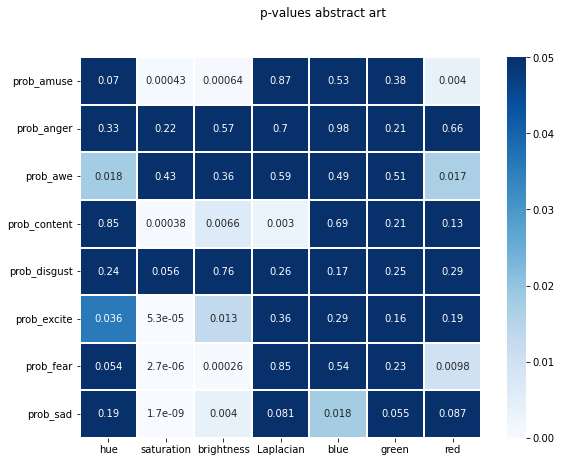

In [33]:
p_val = get_pvals(df_ab)
out_pdf = p_join(PROJDIR,'abstractart_pval.pdf')
pdf = matplotlib.backends.backend_pdf.PdfPages(out_pdf)
plt.figure(figsize=(9,7))
heat_map = sns.heatmap( p_val, linewidth = 1 , annot = True, cmap="Blues", vmin=0.0, vmax=0.05)
plt.suptitle("p-values abstract art")
pdf.savefig()
pdf.close()

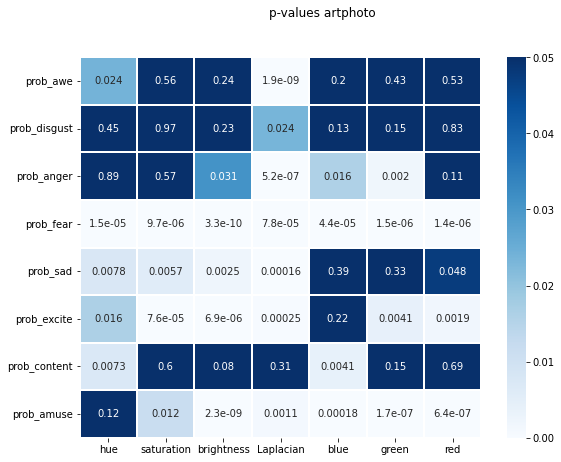

In [34]:
p_val = get_pvals(df_ap)
out_pdf = p_join(PROJDIR,'artphoto_pval.pdf')
pdf = matplotlib.backends.backend_pdf.PdfPages(out_pdf)
plt.figure(figsize=(9,7))
heat_map = sns.heatmap( p_val, linewidth = 1 , annot = True, cmap="Blues", vmin=0.0, vmax=0.05)
plt.suptitle("p-values artphoto")
pdf.savefig()
pdf.close()

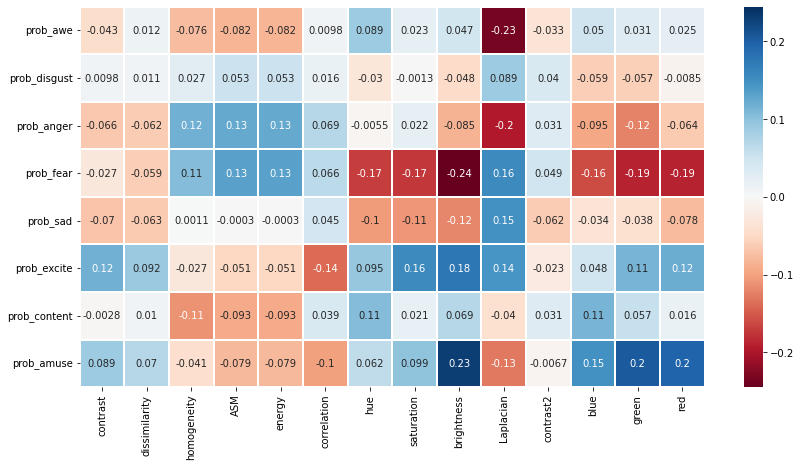

In [ ]:
corr = df_ap.corr(method="spearman")[df_ap.corr().columns[1:9]].T[df_ap.corr().columns[9:]]
plt.figure(figsize=(14,7))
highestval = np.max(abs(corr.values))
# color map centered at 0 (white)
heat_map = sns.heatmap( corr, linewidth = 1 , annot = True, cmap="RdBu", vmin=-highestval, vmax=highestval)
plt.show()

['awe', 'disgust', 'anger', 'fear', 'sad', 'excite', 'content', 'amuse'] float64


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

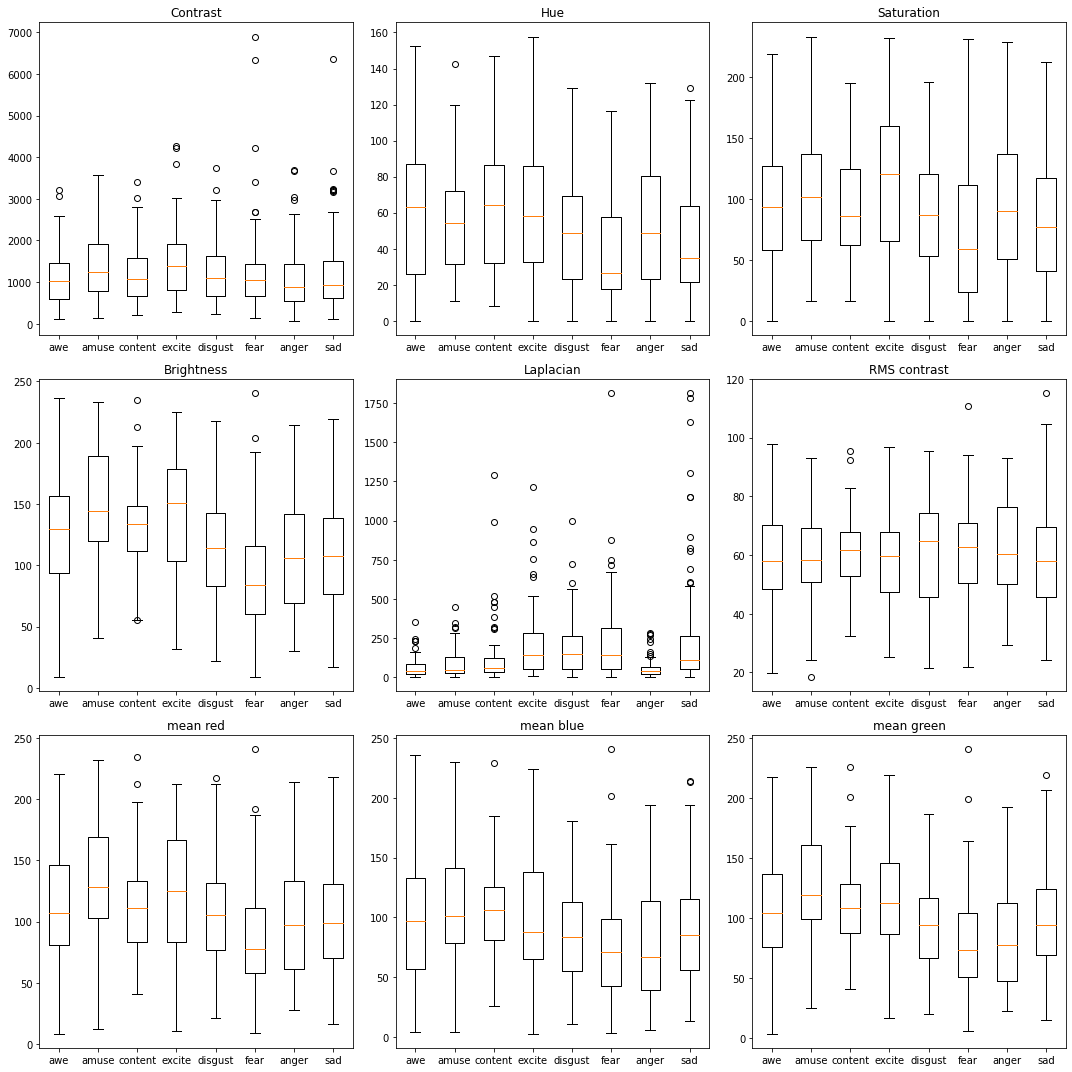

In [ ]:
anger = df_ap[df_ap.Emotion=="anger"]
awe = df_ap[df_ap.Emotion=="awe"]
amuse = df_ap[df_ap.Emotion=="amuse"]
disgust = df_ap[df_ap.Emotion=="disgust"]
fear = df_ap[df_ap.Emotion=="fear"]
content = df_ap[df_ap.Emotion=="content"]
excite = df_ap[df_ap.Emotion=="excite"]
sad = df_ap[df_ap.Emotion=="sad"]

print(emotions_ap, np.array([anger.contrast.values, anger.contrast.values]).dtype)
fig, ax = plt.subplots(3, 3, figsize=(15,15))
ax[0][0].set_title("Contrast")
ax[0][0].boxplot([awe.contrast.values, amuse.contrast.values, content.contrast.values, excite.contrast.values, disgust.contrast.values, fear.contrast.values, anger.contrast.values, sad.contrast.values], labels=["awe","amuse","content","excite","disgust","fear","anger","sad"])
ax[0][1].set_title("Hue")
ax[0][1].boxplot([awe.hue.values, amuse.hue.values, content.hue.values, excite.hue.values, disgust.hue.values, fear.hue.values, anger.hue.values, sad.hue.values], labels=["awe","amuse","content","excite","disgust","fear","anger","sad"])
ax[0][2].set_title("Saturation")
ax[0][2].boxplot([awe.saturation.values, amuse.saturation.values, content.saturation.values, excite.saturation.values, disgust.saturation.values, fear.saturation.values, anger.saturation.values, sad.saturation.values], labels=["awe","amuse","content","excite","disgust","fear","anger","sad"])
ax[1][0].set_title("Brightness")
ax[1][0].boxplot([awe.brightness.values, amuse.brightness.values, content.brightness.values, excite.brightness.values, disgust.brightness.values, fear.brightness.values, anger.brightness.values, sad.brightness.values], labels=["awe","amuse","content","excite","disgust","fear","anger","sad"])
ax[1][1].set_title("Laplacian")
ax[1][1].boxplot([awe.Laplacian.values, amuse.Laplacian.values, content.Laplacian.values, excite.Laplacian.values, disgust.Laplacian.values, fear.Laplacian.values, anger.Laplacian.values, sad.Laplacian.values], labels=["awe","amuse","content","excite","disgust","fear","anger","sad"])
ax[1][2].set_title("RMS contrast")
ax[1][2].boxplot([awe.contrast2.values, amuse.contrast2.values, content.contrast2.values, excite.contrast2.values, disgust.contrast2.values, fear.contrast2.values, anger.contrast2.values, sad.contrast2.values], labels=["awe","amuse","content","excite","disgust","fear","anger","sad"])
ax[2][0].set_title("mean red")
ax[2][0].boxplot([awe.red.values, amuse.red.values, content.red.values, excite.red.values, disgust.red.values, fear.red.values, anger.red.values, sad.red.values], labels=["awe","amuse","content","excite","disgust","fear","anger","sad"])
ax[2][1].set_title("mean blue")
ax[2][1].boxplot([awe.blue.values, amuse.blue.values, content.blue.values, excite.blue.values, disgust.blue.values, fear.blue.values, anger.blue.values, sad.blue.values], labels=["awe","amuse","content","excite","disgust","fear","anger","sad"])
ax[2][2].set_title("mean green")
ax[2][2].boxplot([awe.green.values, amuse.green.values, content.green.values, excite.green.values, disgust.green.values, fear.green.values, anger.green.values, sad.green.values], labels=["awe","amuse","content","excite","disgust","fear","anger","sad"])
fig.tight_layout()

In [ ]:
def to_long_mean_df(df, columns, i):
    emotions = df.Emotion.unique()
    emotions.sort()
    df_means = df.groupby(['Emotion']).mean()#.iloc[:,i:]
    df_means = df_means.assign(Emotion=emotions)
    df_means = pd.melt(df_means, id_vars='Emotion', value_vars=columns)
    return df_means
def to_long_df(df, columns, name):
    df_long = pd.melt(df, id_vars='Emotion', value_vars=columns)
    df_long = df_long.assign(dataset=name)
    return df_long

In [ ]:
df_ab = pd.read_csv(p_join(PROJDIR, "abstract_glcm_hsv_laplace_rgb.csv"), sep=',')
df_ab_means = to_long_mean_df(df_ab, df_ab.columns[17:], 15)
df_ab_means = df_ab_means.assign(dataset="abstract")

In [ ]:
df_ap = pd.read_csv(p_join(PROJDIR, "artphoto_glcm_hsv_laplace_rgb.csv"), sep=',')
df_ap_means = to_long_mean_df(df_ap, df_ab.columns[17:], 15)
df_ap_means = df_ap_means.assign(dataset="artphoto")

In [ ]:
df_em6 = pd.read_csv(p_join(PROJDIR, "emotion6_glcm_hsv_laplace_rgb.csv"), sep=',')
df_em6_means = to_long_mean_df(df_em6, df_em6.columns[19:], 16)
df_em6_means = df_em6_means.assign(dataset="emotion6")

In [ ]:
df_wiki = pd.read_csv(p_join(PROJDIR, "wikiart_features.csv"), sep=',')
df_wiki_means = to_long_mean_df(df_wiki, df_wiki.columns[20:], 10)
df_wiki_means = df_wiki_means.assign(dataset="wikiart")

In [ ]:
features = pd.concat([df_ab_means, df_ap_means, df_em6_means, df_wiki_means])
features

,Emotion,variable,value,dataset
0,amuse,hue,54.643476,abstract
1,anger,hue,40.634676,abstract
2,awe,hue,59.137236,abstract
3,content,hue,55.799549,abstract
4,disgust,hue,40.800827,abstract
...,...,...,...,...
67,disgust,red,137.532640,wikiart
68,excitement,red,142.146163,wikiart
69,fear,red,114.960796,wikiart
70,sadness,red,130.736391,wikiart


['hue' 'saturation' 'brightness' 'Laplacian' 'contrast2' 'blue' 'green'
 'red']


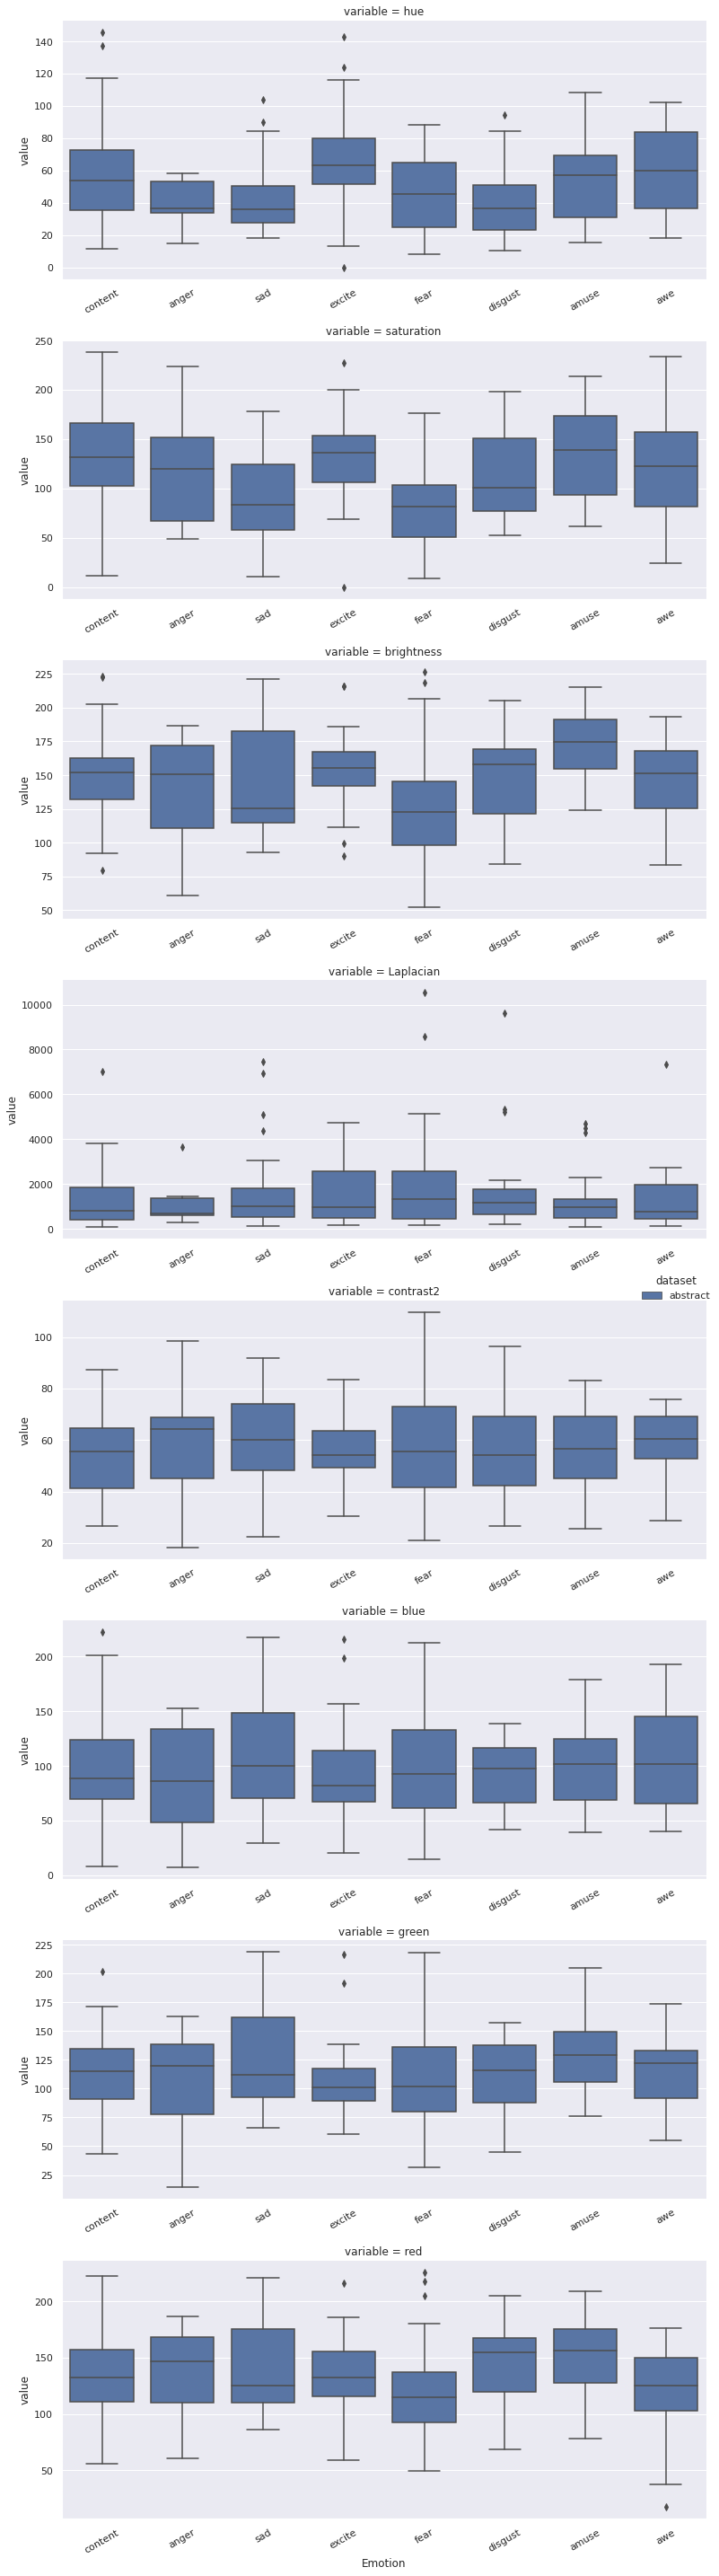

In [ ]:
df_ab_long = to_long_df(df_ab, df_ab.columns[17:], "abstract")
df_ap_long = to_long_df(df_ap, df_ap.columns[17:], "artphoto")
df_wiki_long = to_long_df(df_wiki, df_wiki.columns[20:], "wikiart")
df_em6_long = to_long_df(df_em6, df_em6.columns[19:], "Emotion6")
features_long = pd.concat([df_ab_long, df_ap_long, df_wiki_long, df_em6_long])
print(df_em6_long.variable.unique())
g = sns.catplot(data=df_ab_long, x="Emotion", y="value", col="variable", col_wrap=1, hue="dataset", kind="box", aspect=2, sharex=False, sharey=False)
g.set_xticklabels(rotation=30)
g.fig.tight_layout()